In [1]:
import sys
sys.path.append('../run_analyses/')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# from start_run import *
from support.charting import primaryColors, fullColors, save_fig
from support.load     import loadAllData, methodParams
from support.util     import titles, order, methodTitle, modelTitle

from modelConfig      import models
from util.util        import getLeverNames

from ema_workbench.analysis import parcoords

from IPython.core import display as ICD

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
sns.set_style('white')
data = loadAllData()


 loading data for mordm

--------------------------------
Loading MOEA intertemporal
Loading archives from ../data/mordm/optimize/archives_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Pareto for intertemporal
Loading pareto from ../data/mordm/optimize/nondominated_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Robustness Summary intertemporal
Loading Robust Summary from ../data/mordm/robustness/summary_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
--------------------------------
Loading MOEA plannedadaptive
Loading archives from ../data/mordm/optimize/archives_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_plannedadaptive_NSGAIIHybrid_runs50_nfe100

In [3]:
robustData = {}
for method in data.keys(): 
    robustData[method] = {}
    for model in data[method]['robusts'].keys(): 
        robustData[method][model] = []
        for idx in range(len(data[method]['robusts'][model])):
            df = data[method]['robusts'][model][idx][order('outcome')]
            df = df.rename(columns={'max_P_percent': 'Fraction\nPollution', 'reliability_percent': 'Fraction\nReliability', 
                                          'utility_percent': 'Fraction\nUtility', 'inertia_percent': 'Fraction\nInertia'})
            robustData[method][model].append(df)

In [4]:
def robust_parallel_axes(robust, color): 
    sns.set_palette(sns.light_palette(color, n_colors=robust.shape[0]))

    limits = parcoords.get_limits(robust)
    limits.iloc[0, :] = 0
    limits.iloc[1, :] = 1

    axes = parcoords.ParallelAxes(limits, rot=0, fontsize=12)
    
    return axes

def reorderDatalabels(kind='method', axes=None): 
    newOrder = [None, None, None]
    if kind == 'method': 
        for item in axes.datalabels: 
            if item[0] == methodTitle['mordm']: 
                newOrder[0] = item
            elif item[0] == methodTitle['multi']: 
                newOrder[1] = item
            else: 
                newOrder[2] = item
    elif kind == 'model': 
        for item in axes.datalabels: 
            if item[0] == modelTitle['dps'].replace('\n',' '): 
                newOrder[2] = item
            elif item[0] == modelTitle['plannedadaptive'].replace('\n',' '): 
                newOrder[1] = item
            else: 
                newOrder[0] = item
    axes.datalabels = newOrder
    return axes

def parallelRobustSummary(model, robustData, root=''): 
    axes = robust_parallel_axes(robustData['mordm'][model][0], primaryColors[model]['mordm'])
    axes.plot(robustData['mordm'][model][0], linewidth=0.5)
    axes.fig.suptitle(methodTitle['mordm'], fontsize=14, weight='bold', y = 1.03)
    save_fig(axes.fig, 'images/robust','parallel_mordm_' + model)
    plt.show()

    axes = robust_parallel_axes(robustData['multi'][model][0], primaryColors[model]['multi'])
    colors = list(reversed(fullColors[model]['multi']))
    for idx, robust in enumerate(list(reversed(robustData['multi'][model]))): 
        axes.plot(robust, color=colors[idx], linewidth=0.5)
    axes.fig.suptitle(methodTitle['multi'], fontsize=14, weight='bold', y = 1.03)
    save_fig(axes.fig, 'images/robust','parallel_multi_' + model + '_' + root)
    plt.show()

    axes = robust_parallel_axes(robustData['moro'][model][0], primaryColors[model]['moro'])
    axes.plot(robustData['moro'][model][0], linewidth=0.5, color=primaryColors[model]['moro'])
    axes.fig.suptitle(methodTitle['moro'], fontsize=14, weight='bold', y = 1.03)
    save_fig(axes.fig, 'images/robust','parallel_moro_' + model + '_' + root)
    plt.show()

# Separate Pareto Results

### DPS

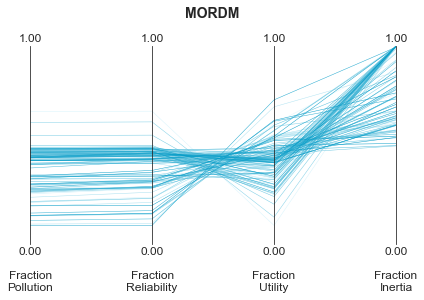

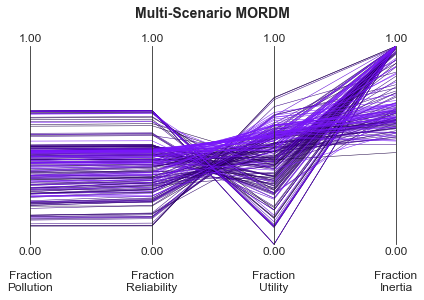

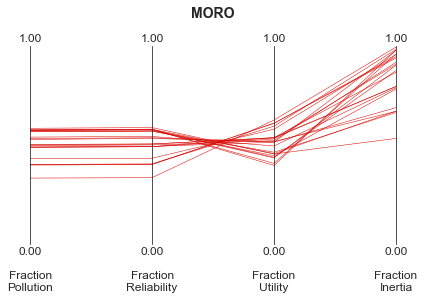

In [5]:
parallelRobustSummary('dps',robustData)

### Planned Adaptive DPS

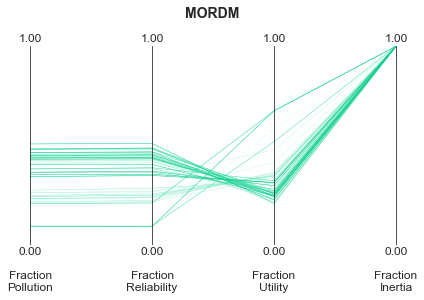

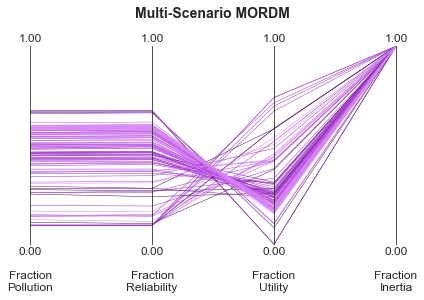

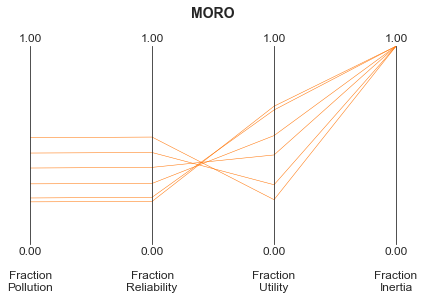

In [6]:
parallelRobustSummary('plannedadaptive',robustData)

### Intertemporal

In [7]:
goodInertia = {}
badInertia = {}
for method in robustData.keys(): 
    goodInertia[method] = {'intertemporal':[]}
    badInertia[method] = {'intertemporal':[]}
    for dat in robustData[method]['intertemporal']:
        goodInertia[method]['intertemporal'].append(dat.loc[dat['Fraction\nInertia'] > 0.5])
        badInertia[method]['intertemporal'].append(dat.loc[dat['Fraction\nInertia'] <= 0.5])

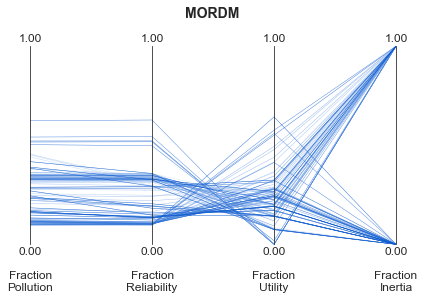

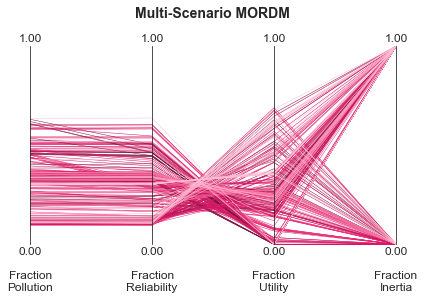

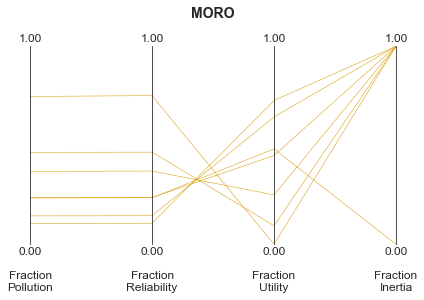

In [8]:
parallelRobustSummary('intertemporal',robustData)

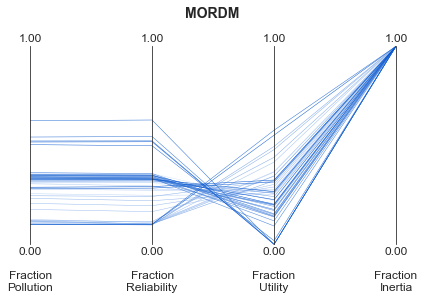

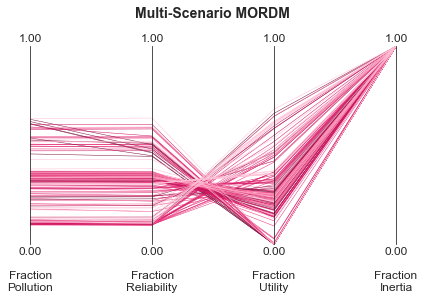

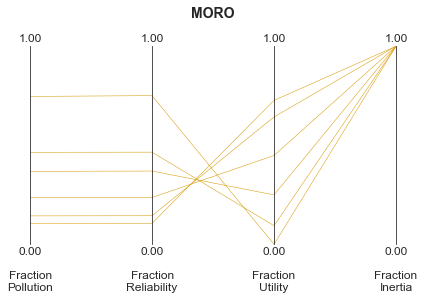

In [9]:
parallelRobustSummary('intertemporal',goodInertia,'good')

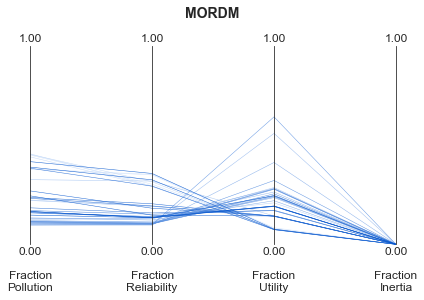

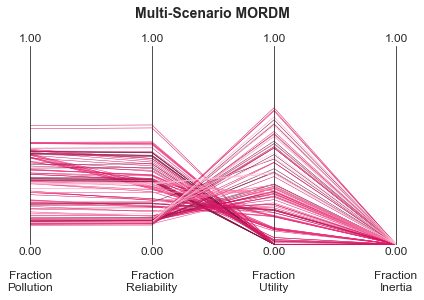

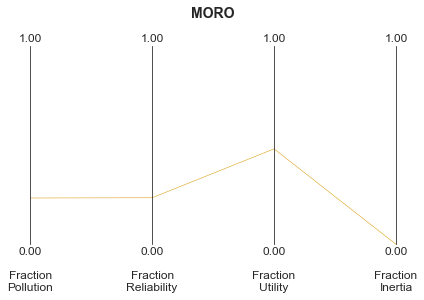

In [10]:
parallelRobustSummary('intertemporal',badInertia,'bad')

# Comparing Robustess Scores

In [46]:
linewidth = 0.3
alpha = 1

mordm = '#1b9e77'
ms_mordm = '#d95f02'
moro = '#7570b3'

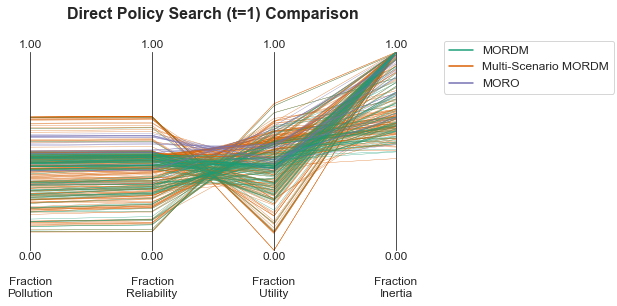

In [47]:
key = 'dps'

axes = robust_parallel_axes(robustData['mordm'][key][0], primaryColors[key]['mordm'])

axes.plot(pd.concat(robustData['multi'][key]), color=ms_mordm,
          label=methodTitle['multi'], linewidth=linewidth, alpha=alpha)


axes.plot(robustData['mordm'][key][0],color=mordm,
          label=methodTitle['mordm'], linewidth=linewidth, alpha=alpha)   
axes.plot(robustData['moro'][key][0],color=moro,
          label=methodTitle['moro'], linewidth=linewidth, alpha=alpha)

axes = reorderDatalabels(kind='method', axes=axes)
axes.legend()
axes.fig.suptitle(modelTitle[key].replace('\n',' ') + ' Comparison', fontsize=16, weight='bold', y = 1.05)
plt.show()

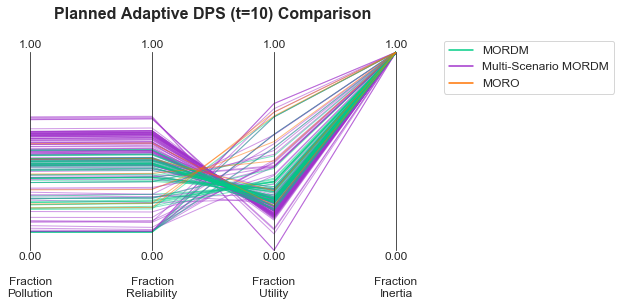

In [33]:
key = 'plannedadaptive'


axes = robust_parallel_axes(robustData['mordm'][key][0], primaryColors[key]['mordm'])

axes.plot(pd.concat(robustData['multi'][key]), color=primaryColors[key]['multi'],
          label=methodTitle['multi'], linewidth=linewidth, alpha=alpha)
axes.plot(robustData['mordm'][key][0],color=primaryColors[key]['mordm'],
          label=methodTitle['mordm'], linewidth=linewidth, alpha=alpha)   
axes.plot(robustData['moro'][key][0],color=primaryColors[key]['moro'],
          label=methodTitle['moro'], linewidth=linewidth, alpha=alpha)

axes = reorderDatalabels(kind='method', axes=axes)
axes.legend()
axes.fig.suptitle(modelTitle[key].replace('\n',' ') + ' Comparison', fontsize=16, weight='bold', y = 1.05)
plt.show()

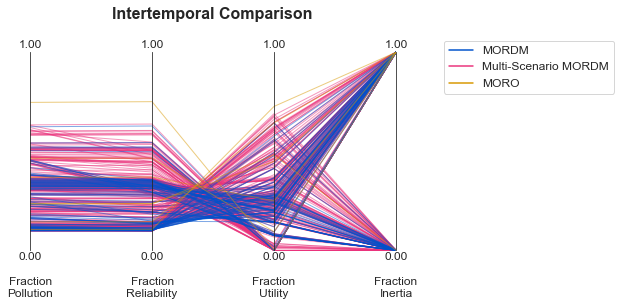

In [34]:
key = 'intertemporal'

axes = robust_parallel_axes(robustData['mordm'][key][0], primaryColors[key]['mordm'])

axes.plot(pd.concat(robustData['multi'][key]), color=primaryColors[key]['multi'],
          label=methodTitle['multi'], linewidth=linewidth, alpha=alpha)
axes.plot(robustData['mordm'][key][0],color=primaryColors[key]['mordm'],
          label=methodTitle['mordm'], linewidth=linewidth, alpha=alpha)   
axes.plot(robustData['moro'][key][0],color=primaryColors[key]['moro'],
          label=methodTitle['moro'], linewidth=linewidth, alpha=alpha)

axes = reorderDatalabels(kind='method', axes=axes)
axes.legend()
axes.fig.suptitle(modelTitle[key].replace('\n',' ') + ' Comparison',
                  fontsize=16, weight='bold', y = 1.05)
plt.show()

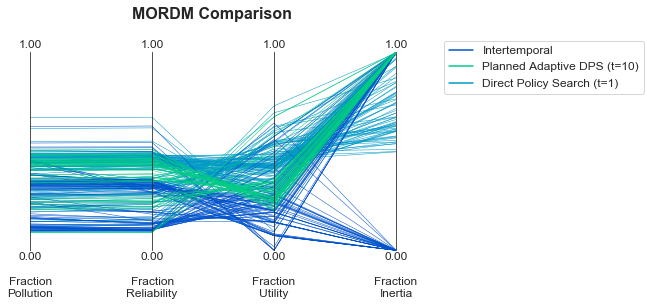

In [15]:
method = 'mordm'

axes = robust_parallel_axes(robustData[method]['dps'][0], primaryColors[key]['mordm'])

axes.plot(robustData[method]['dps'][0],color=primaryColors['dps'][method], label=modelTitle['dps'].replace('\n',' '), linewidth=linewidth) 
axes.plot(robustData[method]['intertemporal'][0],color=primaryColors['intertemporal'][method], label=modelTitle['intertemporal'].replace('\n',' '), linewidth=linewidth)
axes.plot(robustData[method]['plannedadaptive'][0],color=primaryColors['plannedadaptive'][method], label=modelTitle['plannedadaptive'].replace('\n',' '), linewidth=linewidth)

axes = reorderDatalabels(kind='model', axes=axes)
axes.legend()
axes.fig.suptitle(methodTitle[method] + ' Comparison', fontsize=16, weight='bold', y = 1.05)
plt.show()

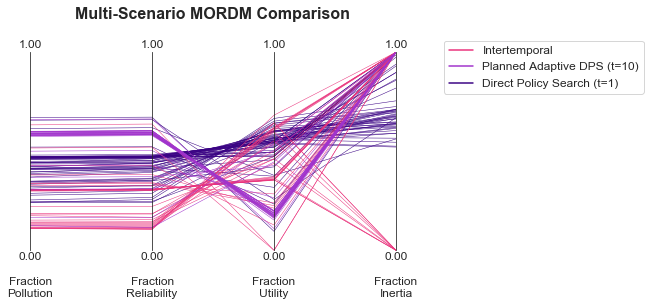

In [16]:
method = 'multi'

axes = robust_parallel_axes(robustData[method]['dps'][0], primaryColors[key]['mordm'])

axes.plot(robustData[method]['dps'][0],color=primaryColors['dps'][method], label=modelTitle['dps'].replace('\n',' '), linewidth=linewidth) 
axes.plot(robustData[method]['intertemporal'][0],color=primaryColors['intertemporal'][method], label=modelTitle['intertemporal'].replace('\n',' '), linewidth=linewidth)
axes.plot(robustData[method]['plannedadaptive'][0],color=primaryColors['plannedadaptive'][method], label=modelTitle['plannedadaptive'].replace('\n',' '), linewidth=linewidth)

axes = reorderDatalabels(kind='model', axes=axes)
axes.legend()
axes.fig.suptitle(methodTitle[method] + ' Comparison', fontsize=16, weight='bold', y = 1.05)
plt.show()

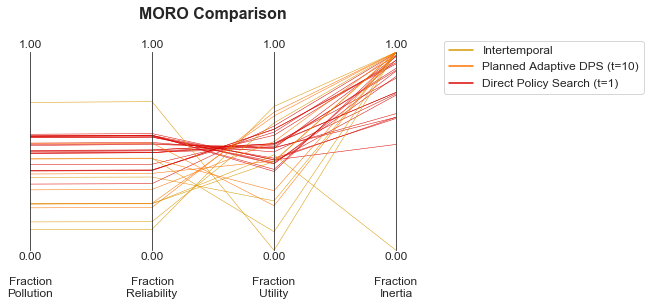

In [17]:
method = 'moro'

axes = robust_parallel_axes(robustData[method]['dps'][0], primaryColors[key]['mordm'])

axes.plot(robustData[method]['dps'][0],color=primaryColors['dps'][method], label=modelTitle['dps'].replace('\n',' '), linewidth=linewidth) 
axes.plot(robustData[method]['intertemporal'][0],color=primaryColors['intertemporal'][method], label=modelTitle['intertemporal'].replace('\n',' '), linewidth=linewidth)
axes.plot(robustData[method]['plannedadaptive'][0],color=primaryColors['plannedadaptive'][method], label=modelTitle['plannedadaptive'].replace('\n',' '), linewidth=linewidth)

axes = reorderDatalabels(kind='model', axes=axes)
axes.legend()
axes.fig.suptitle(methodTitle[method] + ' Comparison', fontsize=16, weight='bold', y = 1.05)
plt.show()

# Robust Value Ranges

In [48]:
def showRobustRanges(model, robustData):
    leverVals = []
    for method in order('method'):
        data = pd.concat(robustData[method][model])
        for rob in data.columns: 
            robVals = data[rob]
            df = pd.DataFrame(robVals)
            df.columns = ['value']
            df['method'] = method
            df['robust_outcome'] = rob
            leverVals.append(df)

    df = pd.concat(leverVals)
    pal = {'mordm': primaryColors[model]['mordm'],'multi': primaryColors[model]['multi'],'moro': primaryColors[model]['moro']}
    for tp in ['violin','box']: 
        g = sns.factorplot(x="method", y="value", col="robust_outcome", palette=pal,
                           data=df, kind=tp,
                           size=4, aspect=.7).set_titles("{col_name}".replace('\n',' '))    
        g.set_axis_labels('', "Value").set_xticklabels(['MORDM','Multi-Scenario\nMORDM','MORO'])
        plt.suptitle('Robust Outcome Ranges for ' + modelTitle[model].replace('\n',' '), fontsize=16,weight='bold',y=1.05)
        
        save_fig(g, 'images/robust/', 'outcomeranges_' + tp + '_' + model)
        
        plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


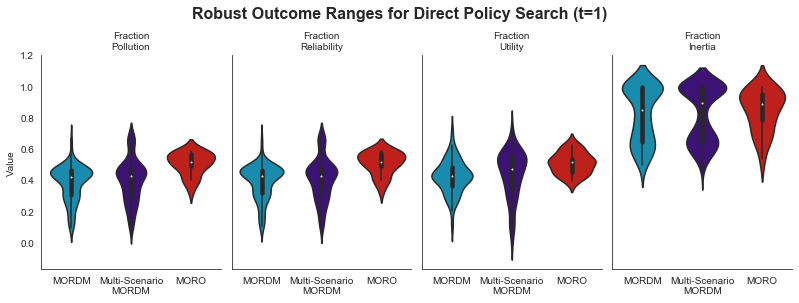

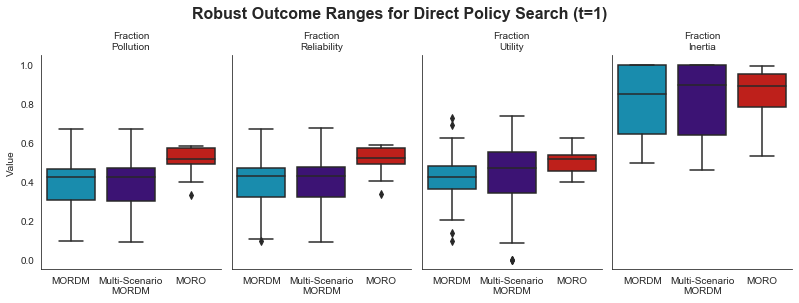

In [49]:
showRobustRanges('dps', robustData)

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


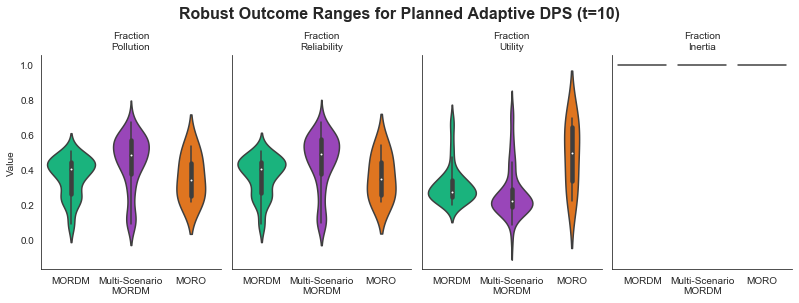

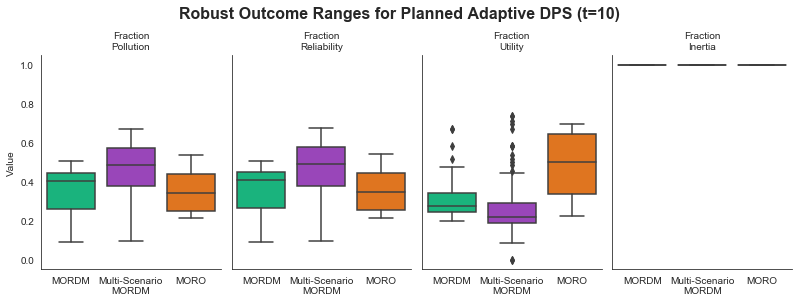

In [50]:
showRobustRanges('plannedadaptive', robustData)

In [ ]:
showRobustRanges('intertemporal', robustData)

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
